In [1]:
# from matplotlib import style
# style.use('fivethirtyeight')

# data science
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

# Reflect Tables into SQLAlchemy ORM

In [2]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# INSPECT - used code as is from class examples and added inspect to the import above

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [4]:
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect an existing database into a new model
Base.prepare(autoload_with=engine)

In [5]:
# View all of the classes that automap found
print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.measurement'>, <class 'sqlalchemy.ext.automap.station'>]


In [6]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.  The most recent date would be the max date.
query = "SELECT max(date) from measurement"

with engine.connect() as conn:
    print(conn.execute(text(query)).fetchall())

[('2017-08-23',)]


In [10]:
# Calculate the date one year from the last date in data set.  Used Xpert for some of this
query = "SELECT DATE(MAX(strftime('%Y-%m-%d %H:%M:%S', date)), '-1 year') AS max_date FROM measurement"
with engine.connect() as conn:
    result = conn.execute(text(query)).fetchall()
    last_year = result[0][0]  # Extract last years date to use in future queries

print(last_year)

2016-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

#Query the database to get the data using one year prior from the max date to get the last 12 months (WHERE CLAUSE)
#Order in ascending date order (ORDER BY)
query = """
    SELECT
        date,
        station,
        prcp
    FROM
        measurement
    WHERE
        date >= '2016-08-23'
    ORDER BY
        date asc;
"""

#Get the data in a dataframe for further analysis
climate_prcp_df = pd.read_sql(text(query), con=engine)
climate_prcp_df.head()

# Sort the dataframe by date
climate_prcp_df["Date"] = pd.to_datetime(climate_prcp_df['date'])
climate_prcp_df = climate_prcp_df.sort_values(by="Date", ascending=True).reset_index(drop=True)

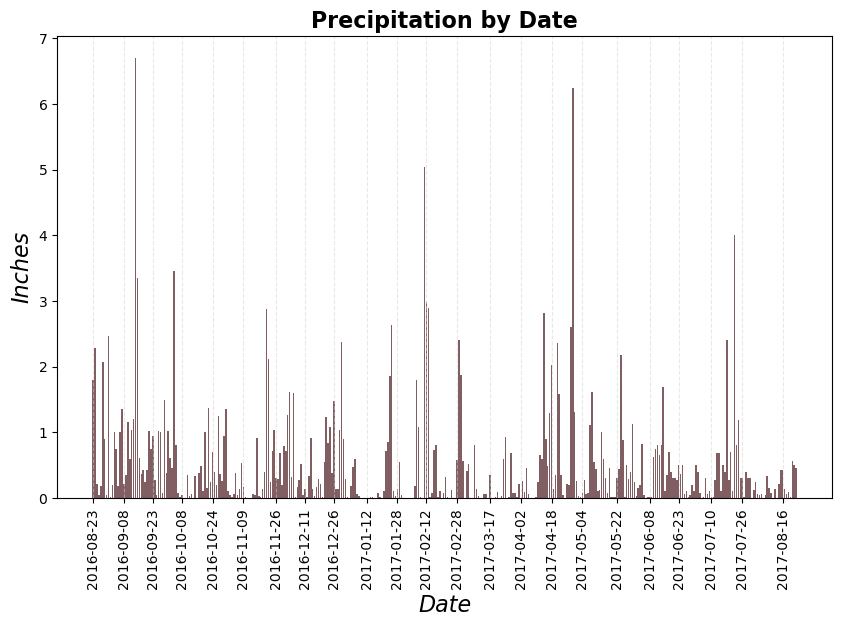

In [12]:
#1 lines of Code from XPERT so that I could use it in plt.xticks
x_ticks = climate_prcp_df['date'][::100]  # Extract every 50th date from the 'date' column

#Plot BAR Chart
x = climate_prcp_df.date
y = climate_prcp_df.prcp
colors = ['#805E61']
plt.figure(figsize=(10, 6))
plt.bar(x, y, color=colors,alpha=1.0, align="center")
# Add labels and title
plt.xlabel('Date', fontstyle='italic', fontsize=16)
plt.ylabel('Inches', fontstyle='italic', fontsize=16)
plt.title('Precipitation by Date', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, )  # Rotate x-axis labels for better readability
plt.xticks(ticks=x_ticks, rotation=90)  # Set specific ticks and labels
plt.grid(color='lightgrey', axis='x', linestyle='--', alpha=0.50)
#Display the plot

plt.show()


In [13]:
#Use Pandas to print the summary statistics for the precipitation data.
climate_prcp_df.prcp.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
query = """
    SELECT
        count(id)
    FROM
        station
"""

with engine.connect() as conn:
    print(conn.execute(text(query)).fetchall())

[(9,)]


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

#Group by Station to get a count of rows by station
#Bring back station also so that we know which station goes with each count
#Order by station descending so that the stations with the most rows are first in the output
query = """
    SELECT
        measurement.station,
        name,
        count(*) as num_stations
    FROM
        measurement
    JOIN 
        station on measurement.station = station.station
    GROUP BY
        name
    ORDER BY
        num_stations desc
"""

station_count_df= pd.read_sql(text(query), con=engine)
station_count_df.head(10)

,station,name,num_stations
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query = """
    SELECT
        min(tobs) as lowest_temp,
        avg(tobs) as average_temp,
        max(tobs) as highest_temp
    FROM
        measurement
    WHERE
        station = 'USC00519281';
"""

temp_stats_df = pd.read_sql(text(query), con=engine)
temp_stats_df.head()

,lowest_temp,average_temp,highest_temp
0,54.0,71.663781,85.0


In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = """
    SELECT
        date,
        station,
        tobs as TOBS
    FROM
        measurement
    WHERE
        date >= '2016-08-23'
        and station = 'USC00519281'
    ORDER BY
        date ASC;
"""

station_df = pd.read_sql(text(query), con=engine)
station_df.head()

,date,station,TOBS
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


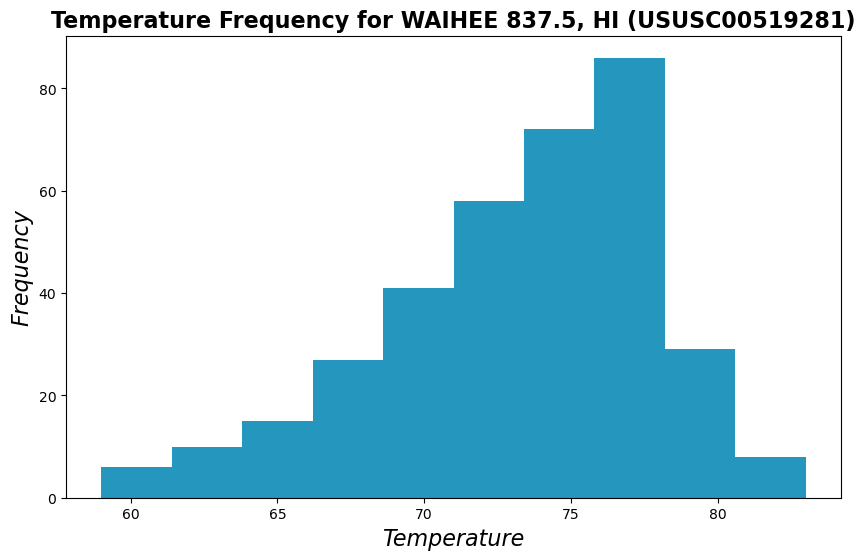

In [37]:
plt.figure(figsize=(10,6))
plt.hist(station_df.TOBS, color="#2596be")
plt.xlabel("Temperature", fontstyle='italic', fontsize=16)
plt.ylabel("Frequency", fontstyle='italic', fontsize=16)
plt.title("Temperature Frequency for WAIHEE 837.5, HI (USUSC00519281)",fontsize=16, fontweight='bold')
plt.show()

# Close Session

In [35]:
# Close Session
session.close()